# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 



In [1]:
import os, sys
sys.path.insert(1, os.path.abspath("../../../"))  # for dowhy source code

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False)
df=data['df']
df.head()

,X0,X1,Z0,Z1,W0,W1,W2,W3,v0,y
0,-0.423069,-0.783912,1.0,0.595267,-1.719039,1.133622,2.154847,2.093053,24.336479,168.434975
1,-0.671984,-0.517552,1.0,0.840097,-0.871639,1.240345,2.513988,1.144102,32.005832,244.808533
2,-0.408754,-1.224234,1.0,0.841418,-2.992127,1.947631,1.178079,0.364007,20.560389,105.083930
3,-1.797735,-0.810235,1.0,0.469800,-1.097293,-0.831213,0.490426,-0.229491,8.713406,34.353637
4,-0.579162,-3.119641,1.0,0.691993,-0.117981,0.009197,0.169698,2.553771,17.375187,-28.550935


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


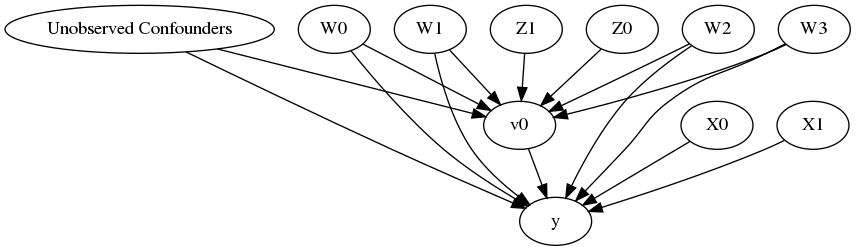

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W0', 'W3', 'W1', 'Unobserved Confounders', 'W2']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W3,W1,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)



# Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W3+W1+W2+v0*X1+v0*X0


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W3,W1,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W0+W3+W1+W2+v0*X1+v0*X0
## Estimate
Value: 10.000000000000007



# EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DMLCateEstimator". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W3+W1+W2


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W3,W1,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W0+W3+W1+W2
## Estimate
Value: 8.578440374266151



In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 6.531368733675461


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W3+W1+W2


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W3,W1,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W0+W3+W1+W2
## Estimate
Value: 6.478668642785378



### CATE Object and Confidence Intervals

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DMLCateEstimator",
                                     target_units = lambda df: df["X0"]>1, 
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': 'bootstrap',
                                                            }
                                              })
print(dml_estimate)
print(dml_estimate.cate_estimates[:10])
print(dml_estimate.effect_intervals)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W3+W1+W2
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 out of 100 | elapsed:  1.1min remaining:   27.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W3,W1,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W0+W3+W1+W2
## Estimate
Value: 8.59526782752452

[[11.26396103]
 [10.54322021]
 [ 8.16997949]
 [ 4.86061276]
 [11.09707173]
 [-2.36778738]
 [ 4.65848744]
 [ 6.6349523 ]
 [ 7.01785881]
 [ 9.61921864]]
(array([[10.7209148 ],
       [10.05703784],
       [ 7.82636093],
       ...,
       [10.37314163],
       [ 5.89648783],
       [14.28637593]]), arra

[Parallel(n_jobs=-1)]: Done  71 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DMLCateEstimator",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W3+W1+W2


[[10.98805765]
 [13.07006079]
 [10.63717349]
 [11.88142705]
 [12.24428257]
 [14.27632508]
 [13.19014829]
 [11.06457798]
 [11.51427196]
 [12.50204303]]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)
dml_estimate

# Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

## Continuous treatment, Continuous outcome

In [14]:
from sklearn.linear_model import LogisticRegression
orthoforest_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.ortho_forest.ContinuousTreatmentOrthoForest",
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=False,
                                method_params={"init_params":{
                                                    'n_trees':2, # not ideal, just as an example to speed up computation
                                                    },
                                               "fit_params":{}
                                              })
print(orthoforest_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W3+W1+W2
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   38.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   38.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:  8.6min


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W3,W1,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W0+W3+W1+W2
## Estimate
Value: 8.331353134942322



[Parallel(n_jobs=-1)]: Done 1483 out of 1483 | elapsed: 11.6min finished


## Binary treatment, Binary outcome

In [15]:
data_binary = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W0', 'W3', 'W1', 'Unobserved Confounders', 'W2']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


            X0        X1   Z0        Z1        W0        W1        W2  \
0     1.170983 -0.463676  0.0  0.999261  1.265824 -0.591487  0.187607   
1     1.874968 -1.237442  0.0  0.372351  2.055680 -0.470702 -1.089608   
2    -0.231365  0.227272  0.0  0.517914  1.004229 -1.196373 -2.495002   
3     1.313117  0.065614  0.0  0.793337 -0.316458 -0.459159 -0.455055   
4     0.012586  0.194818  0.0  0.683885 -0.322924 -1.523299 -0.816566   
...        ...       ...  ...       ...       ...       ...       ...   
9995  2.170496 -0.544734  0.0  0.251869  0.903261 -1.776711 -0.312277   
9996  0.359327  0.190037  0.0  0.877978  1.832255 -1.413621 -1.064130   
9997 -0.515581 -2.971678  0.0  0.482088  0.136553  0.119679  0.081736   
9998  0.105968 -1.541644  0.0  0.095357  3.035971 -1.195416 -0.069832   
9999  1.180787 -0.944992  0.0  0.265338  0.176723  1.442231 -1.669103   

            W3     v0      y  
0     0.281102   True   True  
1    -0.175620   True  False  
2    -1.024748  False   True  

NOTE: DRLearner throws an error since it expects the outcome in a 1-D array. This will be fixed soon in the EconML package. 

In [17]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                target_units = lambda df: df["X0"]>1, 
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W3+W1+W2


AssertionError: Can only accept single dimensional outcomes Y! Use Y.ravel().

## Instrumental Variable Method

In [18]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model._instruments)+len(model._effect_modifiers)
dims_tx = len(model._treatment)+len(model._effect_modifiers)
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIVEstimator",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

Using TensorFlow backend.
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W3+W1+W2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/25
10000/10000 [==============================] - 1s 125us/step - loss: 5.7914
Epoch 2/25
10000/10000 [==============================] - 1s 69us/step - loss: 2.7293
Epoch 3/25
10000/10000 [==============================] - 1s 67us/step - loss: 2.5698
Epoch 4/25
10000/10000 [==============================] - 1s 67us/step - loss: 2.5207
Epoch 5/25
10000/10000 [==============================] - 1s 67us/step - loss: 2.4888
Epoch 6/25
10000/10000 [==============================] - 1s 66us/step - loss: 2.4770
Epoch 7/25
10000/10000 [==============================] - 1s 67us/step - loss: 2.4734
Epoch 8/25
10000/10000 [==============================] - 1s 66us/step - loss: 2.4526
Epoch 9/25
10000/10000 [==============================] - 1s 67us/step - loss: 2.4543
Epoch 10/25
10000/10000 [==============================] - 1s 67us/step - loss: 2.4469
Epoch 11/25
10000/10000 [==============================] - 1s 67us/step - loss: 2.4347
Epoch 12/25
10000/10000 [==========================

# Refuting the estimate

### Random 

In [19]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W3+W1+W2+w_random


Refute: Add a Random Common Cause
Estimated effect:(12.13683678878986,)
New effect:(13.248034250593435,)



### Adding an unobserved common cause variable

In [20]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W3+W1+W2


Refute: Add an Unobserved Common Cause
Estimated effect:(12.13683678878986,)
New effect:(13.196059198878597,)



### Replacing treatment with a random (placebo) variable

In [21]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+W3+W1+W2


Refute: Use a Placebo Treatment
Estimated effect:(12.13683678878986,)
New effect:(0.0,)



### Removing a random subset of the data

In [22]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W3+W1+W2


Refute: Use a subset of data
Estimated effect:(12.13683678878986,)
New effect:(13.150007335670214,)



More refutation methods to come, especially specific to the CATE estimators.